<a href="https://colab.research.google.com/github/sekunder/BMM2017/blob/master/Orientation_Selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval and loading and Matplotlib import
#get the data
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

#load it into a dict
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())
print(dat['sresp'].shape)
N_neurons = dat['sresp'].shape[0]

#import pyplot and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* dat['sresp']: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* dat['run']: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* dat['istim']: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['u_spont']: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* dat['v_spont']: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* dat['u_spont'] @ dat['v_spont']: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

In [3]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 

# Number of components to use
n_cmp = 20

Z = zscore(dat['sresp'], axis=1)
p = PCA(n_components = n_cmp)
p.fit_transform(Z.T)
X = p.components_@Z

In [50]:
# Using mutual information between stimulus and response as a proxy for "orientation selectivity"

MIRS = np.zeros(N_neurons)
HRS = np.zeros(N_neurons)

# hist_bins = 20
R_bins = 10
S_bins = 10
P_S, S_bins = np.histogram(dat['istim'], density=True, bins=S_bins)
# print(P_S)
for neuron in range(N_neurons):
  P_R, R_bins = np.histogram(Z[neuron, :], density=True, bins=R_bins)
  P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
                                              bins=[R_bins, S_bins], density=True)
  # valid_x, valid_y = np.where(P_RS!=0)
  P_R_P_S = np.outer(P_R, P_S)
  summands_MI = (P_RS * np.log2(P_RS / P_R_P_S, out=np.zeros_like(P_RS), where=P_R_P_S!=0))
  # MIRS[neuron] = np.sum(np.where(~np.isnan(summands_MI)))
  MIRS[neuron] = np.sum(summands_MI, where=~np.isnan(summands_MI))

for neuron, mi in zip(favorite_neurons, MIRS[favorite_neurons]):
  print("Neuron",neuron,"has mutual information",mi,"with the stimulus")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Neuron 838 has mutual information 0.01722057140255743 with the stimulus
Neuron 19431 has mutual information 0.3001084183932422 with the stimulus
Neuron 190 has mutual information 0.07120171560552956 with the stimulus
Neuron 6265 has mutual information 0.07040807093522636 with the stimulus
Neuron 16355 has mutual information 0.05255736065421564 with the stimulus


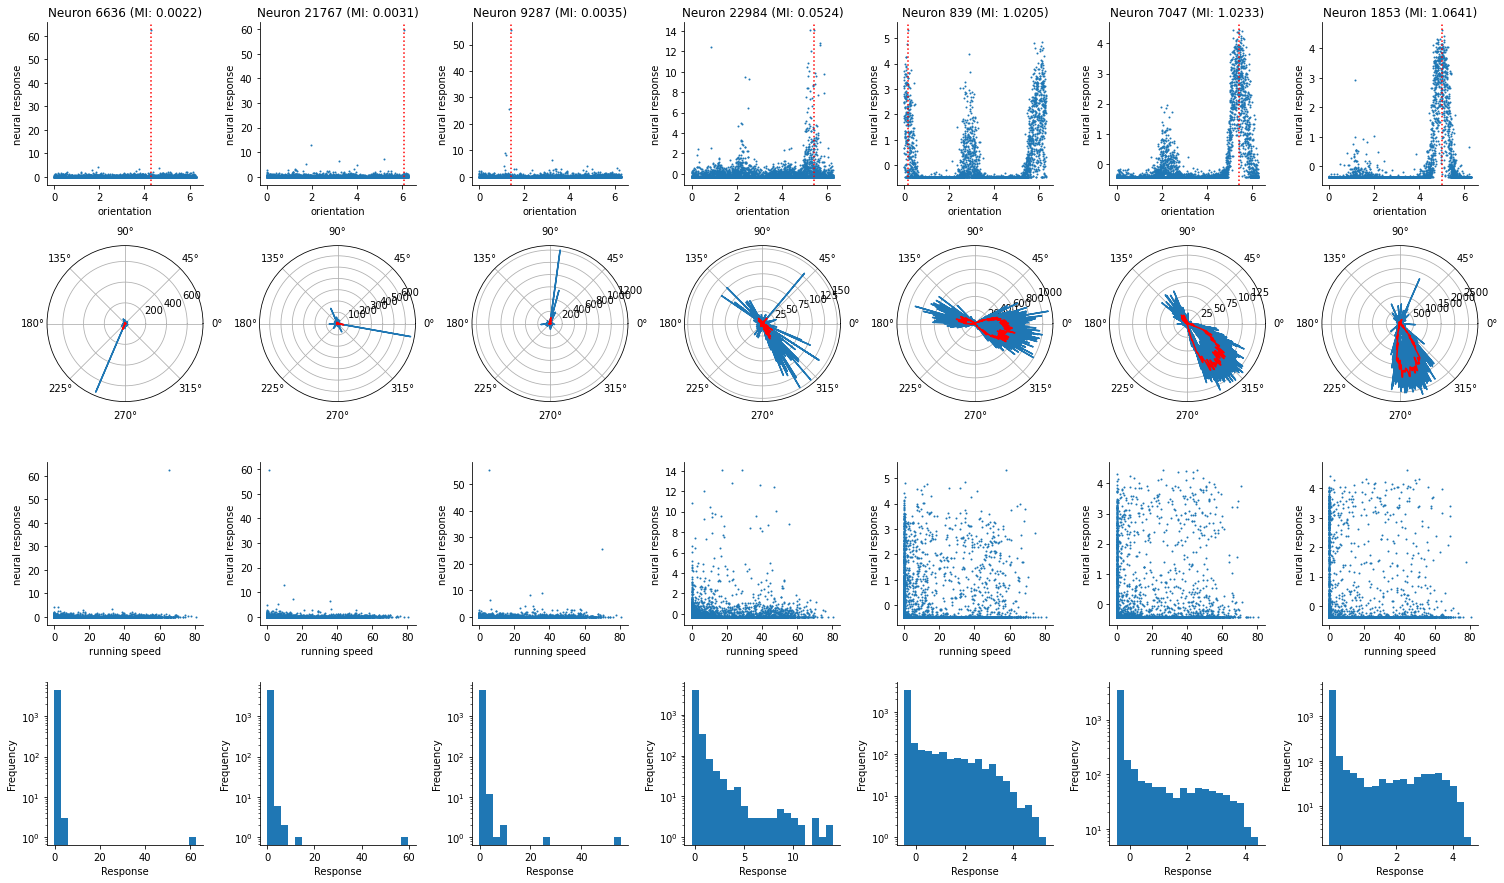

In [73]:
# Starting to play around with individual neuron tuning.
# Ideally, we can find some way to characterize neurons by how "selective" they are
# for orientation, since that's a simple thing to compare between stimuli.
from scipy.ndimage import gaussian_filter1d

fig_rows = 5

R = dat['sresp']
isort = np.argsort(dat['istim'])
R_sorted = R[:,isort]

MI_sort_idx = np.argsort(MIRS)


O = R @ dat['istim'] / R.sum(axis=1)

favorite_neurons = [17, 6, 35, 8, 99]
# favorite_neurons = [8, 99]
# favorite_neurons = np.random.choice(range(N_neurons), size=5)
# favorite_neurons = [838, 19431, 190, 6265, 16355]
favorite_neurons = [MI_sort_idx[0], MI_sort_idx[1], MI_sort_idx[2], MI_sort_idx[len(MI_sort_idx)//2], MI_sort_idx[-3], MI_sort_idx[-2], MI_sort_idx[-1]]
plt.figure(figsize=(3 * len(favorite_neurons), fig_rows * 3))
for i, n in enumerate(favorite_neurons):
  row = 0
  ax = plt.subplot(fig_rows,len(favorite_neurons),i+1 + row * len(favorite_neurons))
  plt.scatter(dat['istim'], Z[n,:], s=1)
  # plt.axvline(O[n], c='red', linestyle=':')
  plt.axvline(dat['istim'][np.argmax(Z[n, :])], c='red', linestyle=':')
  ax.set(xlabel = 'orientation', ylabel = 'neural response', title='Neuron %d (MI: %.4f)'%(n,MIRS[n]))

  row += 1
  ax = plt.subplot(fig_rows,len(favorite_neurons), i+1 + len(favorite_neurons), polar=True)
  plt.polar(sorted(dat['istim']), R_sorted[n,:])
  filtered = gaussian_filter1d(R_sorted[n,:], 5)
  plt.polar(sorted(dat['istim']), filtered, c="red")
  # ax.set(xlabel="orientation", ylabel="response")

  # row += 1
  # ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row * len(favorite_neurons))
  # P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
  #                                             bins=[R_bins, S_bins], density=True)
  # plt.imshow(P_RS)

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i+1 + row*len(favorite_neurons))
  plt.scatter(dat['run'], Z[n,:], s=1)
  ax.set(xlabel = 'running speed', ylabel='neural response')

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row*len(favorite_neurons))
  plt.hist(Z[n,:], bins=hist_bins)
  ax.set(xlabel="Response", ylabel="Frequency", yscale="log")

In [ ]:
 
print(O[favorite_neurons])
print("Max stimulus:",max(dat['istim']),"Min Stimulus:",min(dat['istim']))


[3.08313406 2.88758685 3.29010348 3.14439016 3.08817968]
Max stimulus: 6.282404857491223 Min Stimulus: 0.0006091591363192009


In [11]:
np.where?

## Attempting dPCA 

Below, we try to use dPCA

In [ ]:
#@title Load dPCA code
!git clone https://github.com/machenslab/dPCA.git
import os, sys
sys.path.append("/content/dPCA/python")
from dPCA import dPCA

Cloning into 'dPCA'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 1.28 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (127/127), done.


/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/dPCA/python/dPCA/nan_shuffle.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
# Trying to figure out how to organize the data so dPCA can be used
idx = np.argsort(dat['istim'])
sorted_angles = np.sort(dat['istim'])
indices = np.arange(len(sorted_angles))
# R_binned = np.zeros()
for i in range(20):
  idx_range = indices[((i * np.pi / 10) < sorted_angles) & (sorted_angles < (i+1) * (np.pi / 10))]
  print(min(idx_range), max(idx_range), '# samples: ', max(idx_range) - min(idx_range))
  

0 247 # samples:  247
248 455 # samples:  207
456 682 # samples:  226
683 919 # samples:  236
920 1157 # samples:  237
1158 1410 # samples:  252
1411 1638 # samples:  227
1639 1859 # samples:  220
1860 2075 # samples:  215
2076 2295 # samples:  219
2296 2518 # samples:  222
2519 2770 # samples:  251
2771 3001 # samples:  230
3002 3237 # samples:  235
3238 3455 # samples:  217
3456 3688 # samples:  232
3689 3912 # samples:  223
3913 4155 # samples:  242
4156 4381 # samples:  225
4382 4597 # samples:  215
